(BART_quantile)=
# Quantile Regression with BART
:::{post} Jan 25, 2023
:tags: BART, non-parametric, quantile, regression 
:category: intermediate, explanation
:author: Osvaldo Martin
:::

In [1]:
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb

from scipy import stats

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.0.2+58.g0de909a97.dirty


In [2]:
%config InlineBackend.figure_format = "retina"
RANDOM_SEED = 5781
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

Usually when doing regression we model the conditional mean of some distribution. Common cases are a Normal distribution for continuous unbounded responses, a Poisson distribution for count data, etc.

Quantile regression, instead estimates a conditional quantile of the response variable. If the quantile is 0.5, then we will be estimating the median (instead of the mean), this could be useful as a way of performing robust regression, in a similar fashion as using a Student-t distribution instead of a Normal. But for some problems we actually care of the behavior of the response away from the mean (or median). For example, in medical research, pathologies or potential health risks occur at high or low quantiles, for instance, overweight and underweight. In some other fields like ecology, quantile regression is justified due to the existence of complex interactions between variables, where the effect of one variable on another is different for different ranges of the variable.

## Asymmetric Laplace distribution

At first it could be weird to think which distribution we should use as the likelihood for quantile regression or how to write a Bayesian model for quantile regression. But it turns out the answer is quite simple, we just need to use the asymmetric Laplace distribution. This distribution has one parameter controlling the mean, another for the scale and a third one for the asymmetry. There are at least two alternative parametrization regarding this asymmetric parameter. In terms of $\kappa$ a parameter that goes from 0 to $\infty$ and in terms of $q$ a number between 0 and 1. This later parametrization is more intuitive for quantile regression as we can directly interpret it as the quantile of interest.

On the next cell we compute the pdf of 3 distribution from the Asymmetric Laplace family

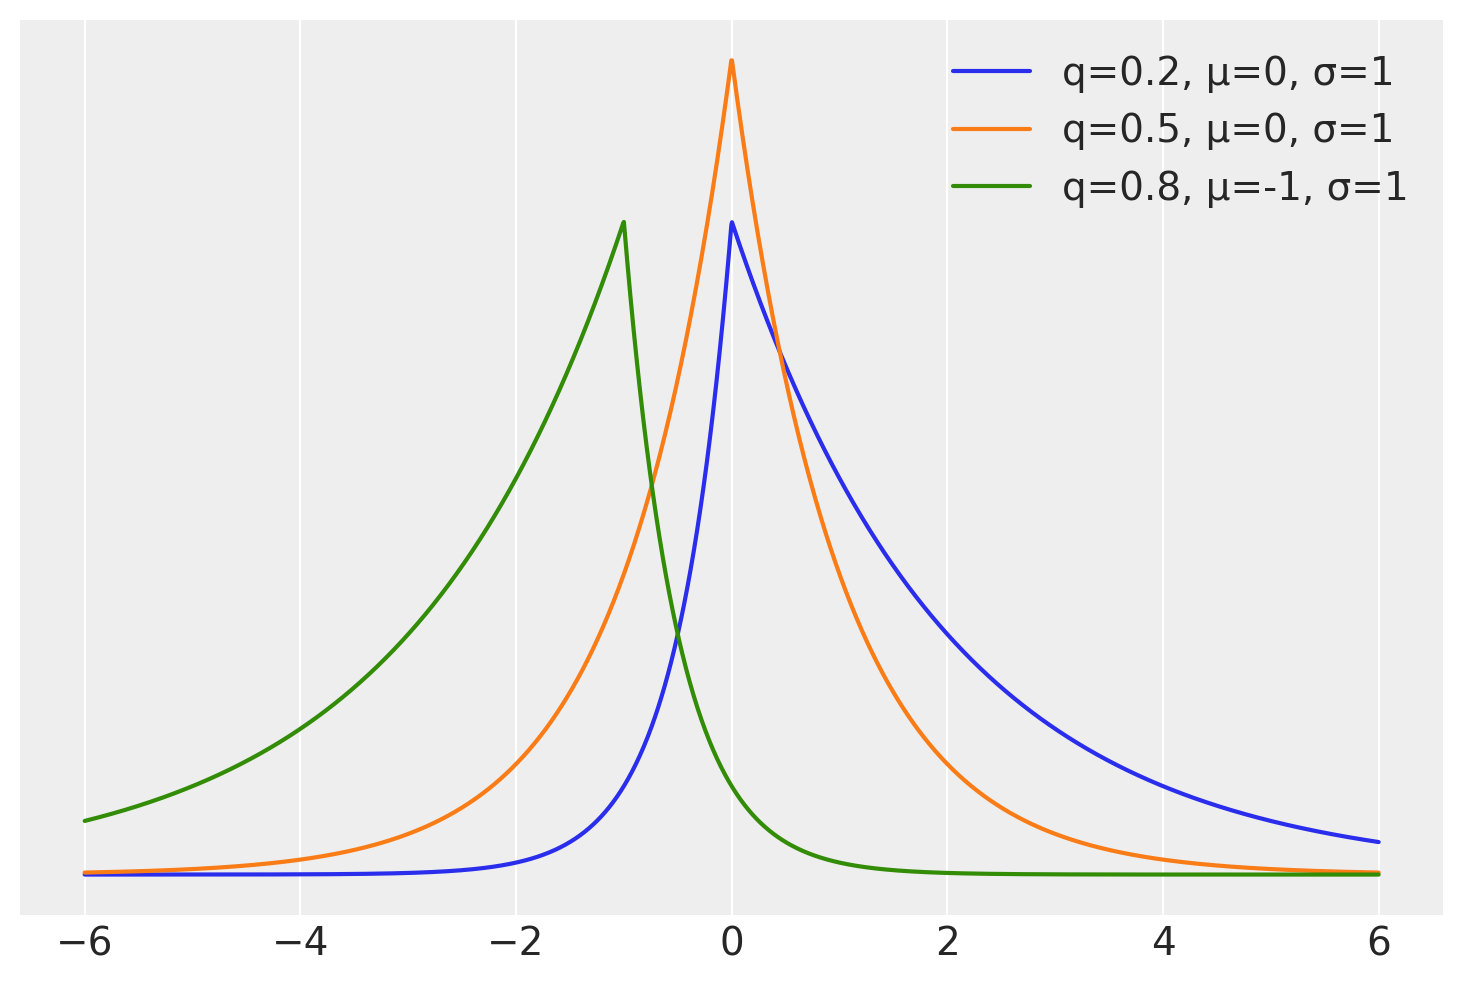

In [3]:
x = np.linspace(-6, 6, 2000)
for q, m in zip([0.2, 0.5, 0.8], [0, 0, -1]):
    κ = (q / (1 - q)) ** 0.5
    plt.plot(x, stats.laplace_asymmetric(κ, m, 1).pdf(x), label=f"q={q:}, μ={m}, σ=1")
plt.yticks([])
plt.legend();

We are going to use a simple dataset to model the Body Mass Index for Dutch kids and young men as a function of their age.

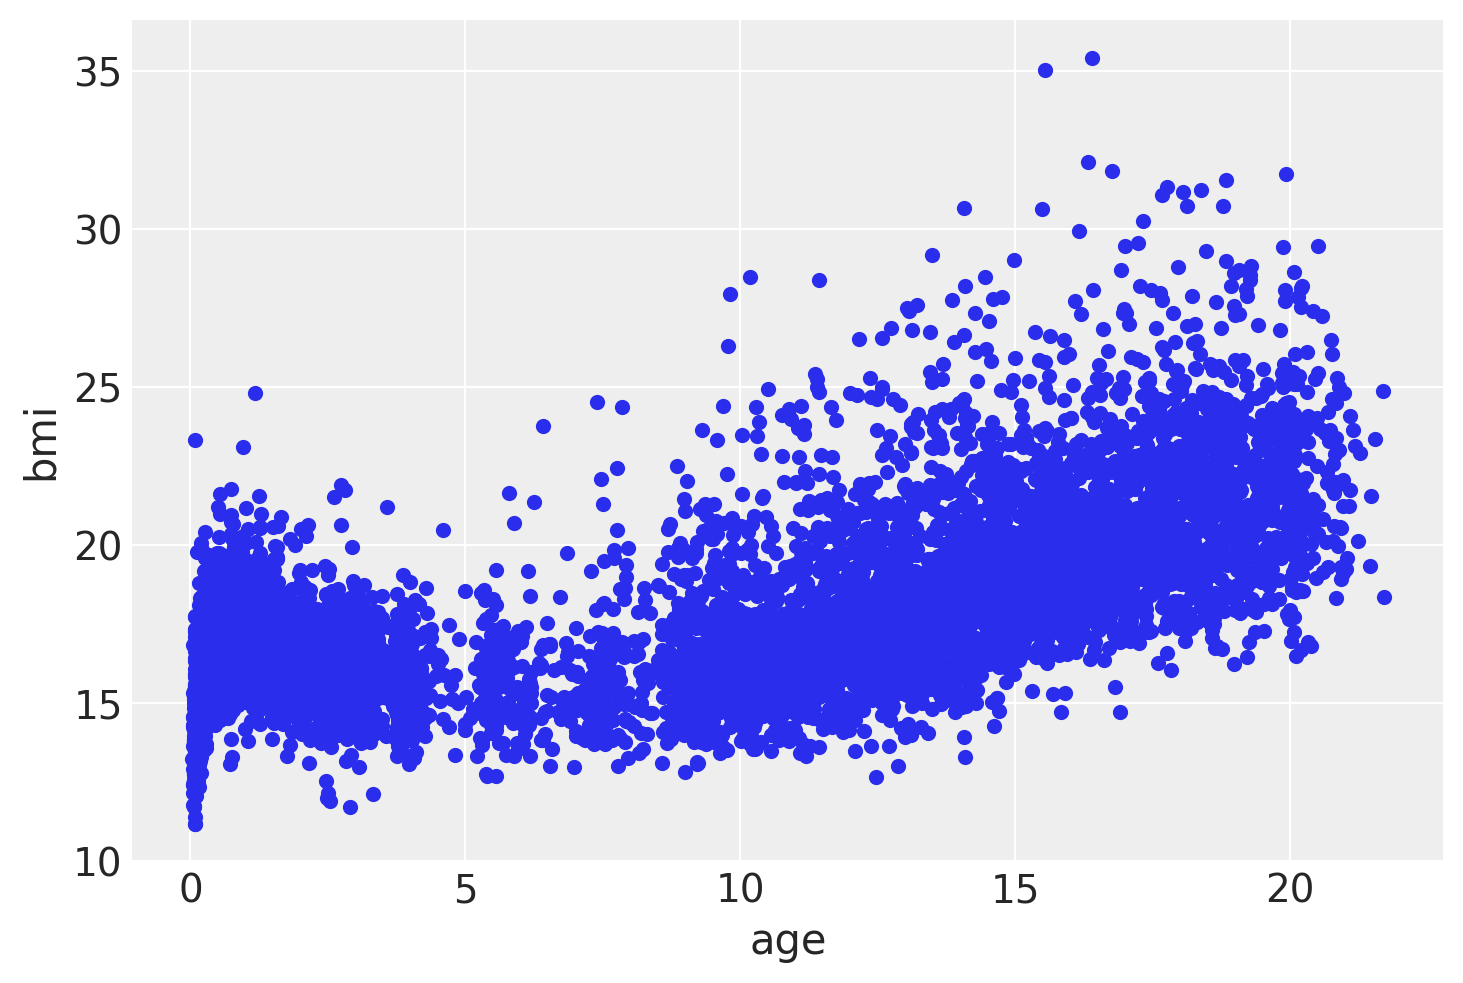

In [4]:
try:
    bmi = pd.read_csv(Path("..", "data", "bmi.csv"))
except FileNotFoundError:
    bmi = pd.read_csv(pm.get_data("bmi.csv"))

bmi.plot(x="age", y="bmi", kind="scatter");

As we can see from the previous figure the relationship between BMI and age is far from linear, and hence we are going to use BART.

We are going to model 3 quantiles, 0.1, 0.5 and 0.9. We can compute this quantity by fitted 3 separated model,  being the sole different the value of `q` of the Asymmetric Laplace distribution. Or we can stack the observed values as in `y_stack` and fit a single model. 

In [5]:
y = bmi.bmi.values
X = bmi.age.values[:, None]


y_stack = np.stack([bmi.bmi.values] * 3)
quantiles = np.array([[0.1, 0.5, 0.9]]).T
quantiles

array([[0.1],
       [0.5],
       [0.9]])

In [6]:
with pm.Model() as model:
    μ = pmb.BART("μ", X, y, shape=(3, 7294))
    σ = pm.HalfNormal("σ", 5)
    obs = pm.AsymmetricLaplace("obs", mu=μ, b=σ, q=quantiles, observed=y_stack)

    idata = pm.sample(compute_convergence_checks=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 265 seconds.


We can see the result of the 3 fitted curves in the next figure. One feature that stand-out is that the gap or distance between the median (orange) line and the two other lines is not the same. Also the shapes of the curve while following a similar pattern, are not exactly the same.

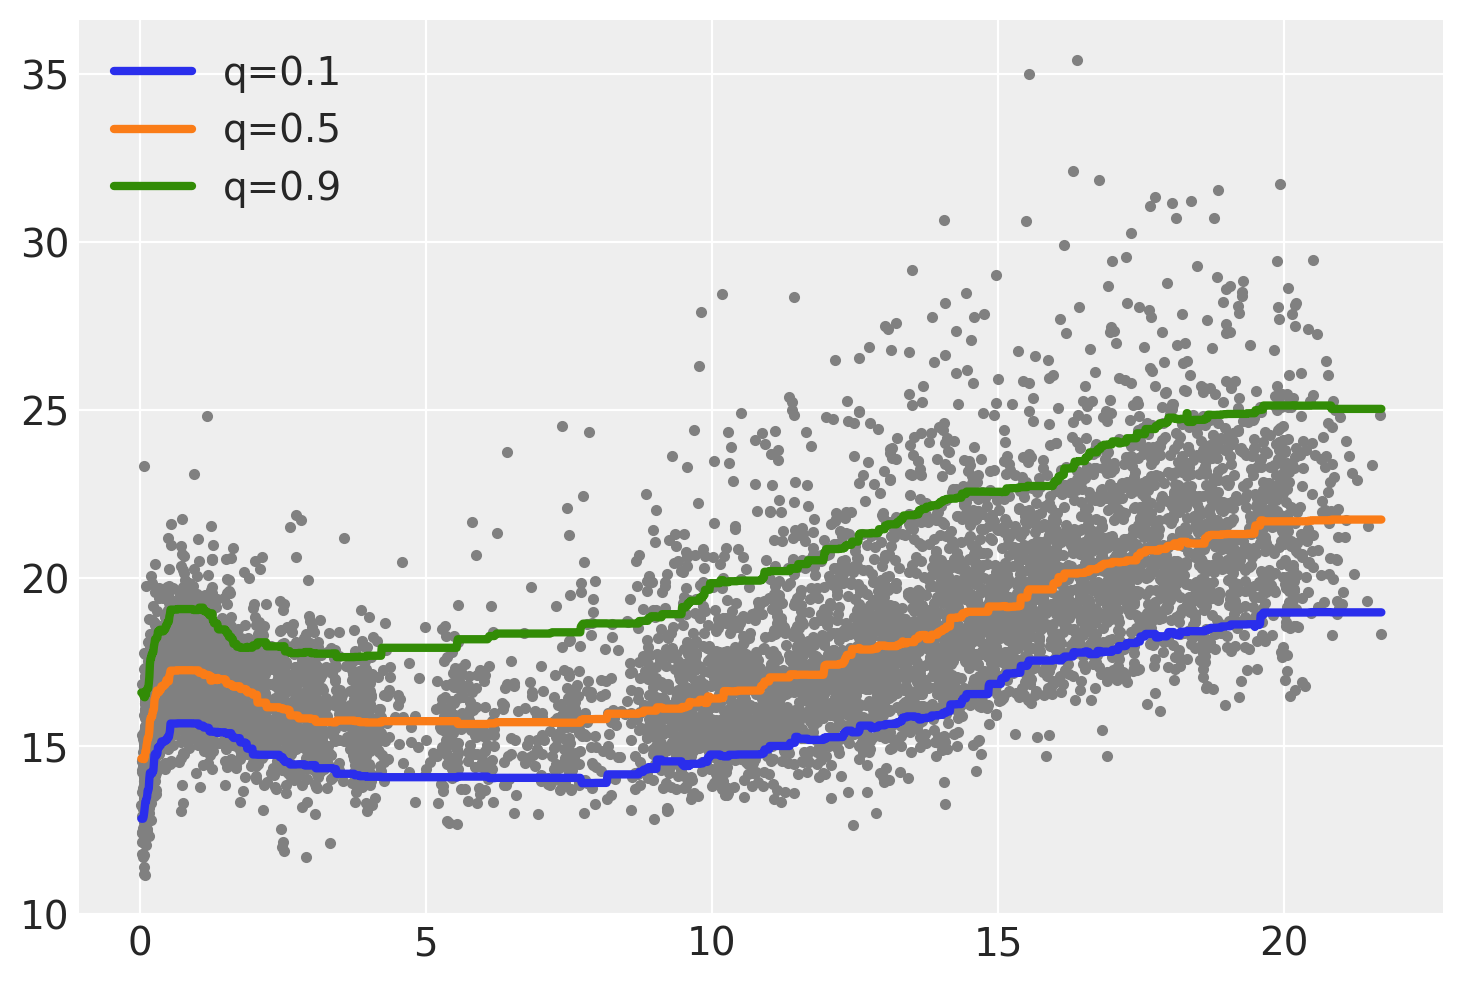

In [7]:
plt.plot(bmi.age, bmi.bmi, ".", color="0.5")
for idx, q in enumerate(quantiles[:, 0]):
    plt.plot(
        bmi.age,
        idata.posterior["μ"].mean(("chain", "draw")).sel(μ_dim_0=idx),
        label=f"q={q:}",
        lw=3,
    )

plt.legend();

 To better understand these remarks let's compute a BART regression with a Normal likelihood and then compute the same 3 quantiles from that fit. 

In [8]:
y = bmi.bmi.values
x = bmi.age.values[:, None]
with pm.Model() as model:
    μ = pmb.BART("μ", x, y)
    σ = pm.HalfNormal("σ", 5)
    obs = pm.Normal("obs", mu=μ, sigma=σ, observed=y)

    idata_g = pm.sample(compute_convergence_checks=False)
    idata_g.extend(pm.sample_posterior_predictive(idata_g))

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
Sampling: [obs]


In [9]:
idata_g_mean_quantiles = idata_g.posterior_predictive["obs"].quantile(
    quantiles[:, 0], ("chain", "draw")
)

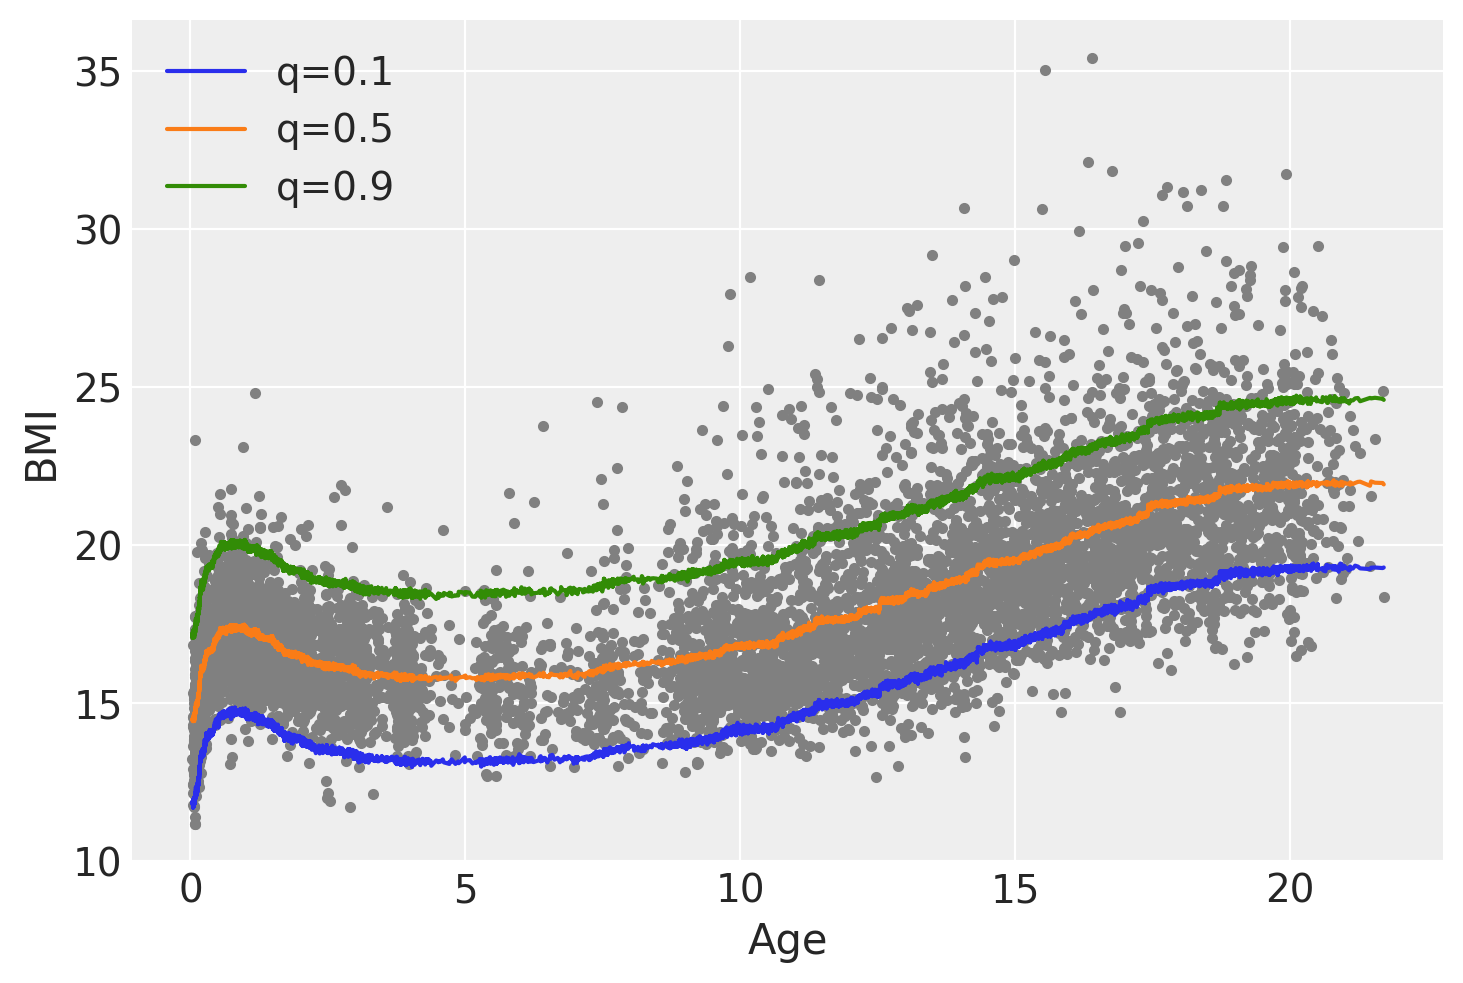

In [10]:
plt.plot(bmi.age, bmi.bmi, ".", color="0.5")
for q in quantiles[:, 0]:
    plt.plot(bmi.age.values, idata_g_mean_quantiles.sel(quantile=q), label=f"q={q:}")

plt.legend()
plt.xlabel("Age")
plt.ylabel("BMI");

We can see that when we use a Normal likelihood, and from that fit we compute the quantiles, the quantiles  q=0.1 and q=0.9 are symetrical with respect to q=0.5, also the shape of the curves is essentially the same just shifted up or down. Additionally the Asymmetric Laplace family allows the model to account for the increased variability in BMI as the age increases, while for the Gaussian family that variability always stays the same.

## Authors
* Authored by Osvaldo Martin in Jan, 2023

## References

:::{bibliography}
:filter: docname in docnames

martin2021bayesian
quiroga2022bart
:::

## Watermark

In [11]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,xarray

Last updated: Sat Mar 04 2023

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.7.0

pytensor: 2.10.1
xarray  : 2023.1.0

scipy     : 1.10.0
matplotlib: 3.5.2
pymc      : 5.0.2+58.g0de909a97.dirty
pymc_bart : 0.3.1
arviz     : 0.14.0
pandas    : 1.5.3
numpy     : 1.23.5

Watermark: 2.3.1



:::{include} ../page_footer.md
:::